<h1 style="color:rgb(0,120,170)">Neural Networks and Deep Learning</h1>
<h2 style="color:rgb(0,120,170)">Gated Recurrent Unit (GRU)</h2>

This notebook is a vanilla implementation of Cho's GRU. Although GRU is ideal for sequence analysis it also works on images... But it is not where you should use it :)

In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import os

In [ ]:
print(torch.__version__)

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, 
                       test_batch_size=1000, 
                       epochs=10,
                       lr=0.01, 
                       momentum=0.5, 
                       seed=1, 
                       log_interval=100,
                       input_size=28, 
                       sequence_length=28, 
                       hidden_size=32, 
                       num_layers=1, 
                       num_classes=10)

torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


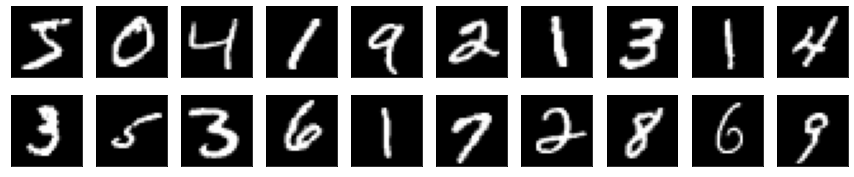

In [4]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

The main difference of how the input is treated is the following: <br>
Whereas for Logistic Regression, ANNs and CNNs the 28$\times$28 pixels are fed as ONE VECTOR to the network, for the LSTM/GRU 28 VECTORS with LENGTH 28 are the input. We interpret every row as one time point. The vanilla pytorch LSTM/GRU implementation takes care of all this by simply providing the 28$\times$28 list. It would also be no problem if the inputs were of different length.

In [5]:
class MyGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MyGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)
    
    def forward(self, x):
        # Set initial hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.gru(x, h0)
        #out, _ = self.gru(x, h0) # alternatively, without setting h0
         
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return F.log_softmax(out, dim=1)

In [6]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data[:,-1].to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data[:,-1].to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [8]:
# Main
t0 = time.time()

model = MyGRU(args.input_size, args.hidden_size, args.num_layers, args.num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    
t1 = time.time() - t0
print(f'Training took {t1/60:.2f} minutes')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292142
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.718241
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.356458
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.203639
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.316218
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.090608
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.198276
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.234266
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.095163
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.216603

Test set: Average loss: 0.1929, Accuracy: 9428/10000 (94.28%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.174412
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.201282
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.114431
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.116253
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.101962
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.084921
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.049596
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.024495
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.05067